In [1]:
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.mixture import GaussianMixture

# from bayesian.train_bn import structure_learning, parameter_learning
# from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
# from bayesian.save_bn import save_structure, save_params, read_structure, read_params
# from bayesian.sampling import generate_synthetics
# from bayesian.calculate_accuracy import parall_accuracy
# from external.libpgm.hybayesiannetwork import HyBayesianNetwork
# from visualization.visualization import draw_BN

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Turbine_Data45.csv')

In [7]:
df.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-08-19 16:10:00+00:00,1723.840739,27.559161,47.471346,0.0,76.799038,63.229199,1751.589089,111.337475,110.699257,42.003815,40.437500,89.00,0.015372,15.702706,2.0,89.00,15.061125
1,2018-08-19 16:20:00+00:00,1713.430541,27.516543,42.126495,0.0,68.203331,63.155119,1759.218300,111.219889,110.578340,37.336724,35.882182,89.00,0.279944,15.780975,2.0,89.00,11.791917
2,2018-08-19 16:40:00+00:00,1724.986578,27.538246,47.375546,0.0,76.601080,62.995341,1752.282056,110.953116,110.334352,42.003815,40.238596,89.00,-0.225979,15.703549,2.0,89.00,13.433922
3,2018-08-19 17:10:00+00:00,1710.218095,27.454070,47.125813,0.0,76.562569,62.964190,1751.914460,110.820297,110.191098,42.003815,40.000000,95.00,0.523854,15.725234,2.0,95.00,13.016989
4,2018-08-19 17:20:00+00:00,1716.371633,27.404938,41.924676,0.0,67.924564,62.840194,1757.314711,110.730811,110.098841,37.333527,35.506944,94.25,0.607706,15.760685,2.0,94.25,12.377344


In [3]:
target_columns = ['BearingShaftTemperature', 'WindSpeed', 'GeneratorWinding2Temperature']
predict_columns = ['ActivePower', 'RotorRPM', 'AmbientTemperatue', 'ReactivePower', 'WindDirection', 'GeneratorRPM']
all_columns = target_columns+predict_columns
all_columns

['BearingShaftTemperature',
 'WindSpeed',
 'GeneratorWinding2Temperature',
 'ActivePower',
 'RotorRPM',
 'AmbientTemperatue',
 'ReactivePower',
 'WindDirection',
 'GeneratorRPM']

In [4]:
target_df = df[target_columns+predict_columns]
target_df

,BearingShaftTemperature,WindSpeed,GeneratorWinding2Temperature,ActivePower,RotorRPM,AmbientTemperatue,ReactivePower,WindDirection,GeneratorRPM
0,47.471346,15.061125,110.699257,1723.840739,15.702706,27.559161,0.015372,89.00,1751.589089
1,42.126495,11.791917,110.578340,1713.430541,15.780975,27.516543,0.279944,89.00,1759.218300
2,47.375546,13.433922,110.334352,1724.986578,15.703549,27.538246,-0.225979,89.00,1752.282056
3,47.125813,13.016989,110.191098,1710.218095,15.725234,27.454070,0.523854,95.00,1751.914460
4,41.924676,12.377344,110.098841,1716.371633,15.760685,27.404938,0.607706,94.25,1757.314711
...,...,...,...,...,...,...,...,...,...
45714,45.711129,3.533445,58.148777,70.044465,9.234004,27.523741,13.775785,178.00,1029.870744
45715,45.598573,3.261231,57.550367,40.833474,9.229370,27.602882,8.088928,178.00,1030.160478
45716,45.462045,3.331839,57.099335,20.777790,9.236802,27.560925,4.355978,178.00,1030.137822
45717,45.343827,3.284468,56.847239,62.091039,9.237374,27.810472,12.018077,190.00,1030.178178


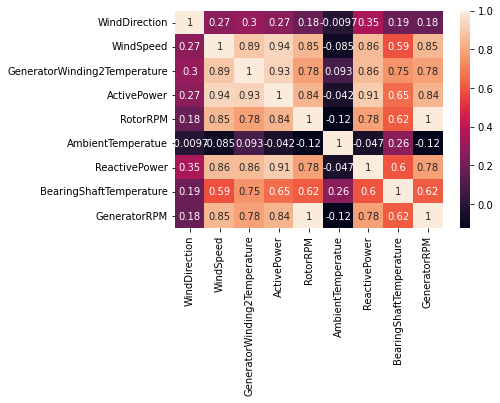

In [15]:
corrMatrix = target_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

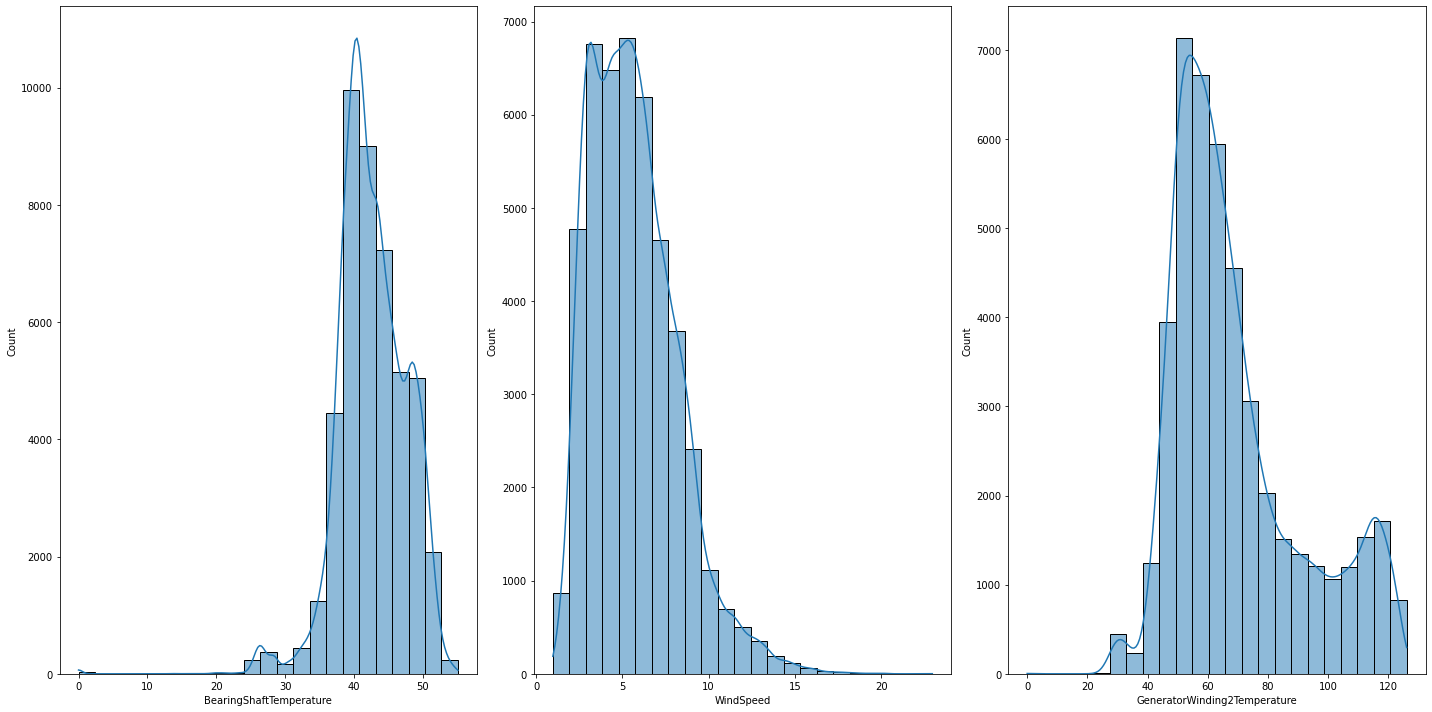

In [10]:
bins_count = [np.rint(np.log10(target_df.shape[0]) * 5), np.rint(1 + 3.32 * np.log10(target_df.shape[0]))]
bins_count = np.array(bins_count, dtype=np.int32)

fig, ax = plt.subplots(1, len(target_columns), figsize=(20, 10), tight_layout=True)

for col_index, column in enumerate(target_columns):
          sns.histplot(
              target_df[column],
              kde=True,
              bins=bins_count[0],
              ax=ax[col_index],
          )

In [5]:
df_var = target_df[target_columns].var()
df_var

BearingShaftTemperature          24.430720
WindSpeed                         6.401850
GeneratorWinding2Temperature    466.647722
dtype: float64

In [6]:
df_mean = target_df[target_columns].mean()
df_mean

BearingShaftTemperature         42.545913
WindSpeed                        5.660227
GeneratorWinding2Temperature    69.249069
dtype: float64

In [7]:
alpha_mom = df_mean ** 2 / df_var
beta_mom = df_var / df_mean
lambda_mom = 1 / df_mean
mu_mom = df_mean
sigma_mom = np.sqrt(df_var)

In [8]:
alpha_mom

BearingShaftTemperature         74.093384
WindSpeed                        5.004518
GeneratorWinding2Temperature    10.276346
dtype: float64

In [9]:
from scipy.stats import gamma, expon, norm, lognorm

In [10]:
alpha_mom

BearingShaftTemperature         74.093384
WindSpeed                        5.004518
GeneratorWinding2Temperature    10.276346
dtype: float64

In [11]:
beta_mom

BearingShaftTemperature         0.574220
WindSpeed                       1.131023
GeneratorWinding2Temperature    6.738686
dtype: float64

In [12]:
type(beta_mom)

pandas.core.series.Series

In [13]:
ls_data = [['a', alpha_mom[0], alpha_mom[1], alpha_mom[2]], 
            ['loc', mu_mom[0], mu_mom[1], mu_mom[2]],
           ['scale', beta_mom[0], beta_mom[1], beta_mom[2]]]

In [14]:
params = pd.DataFrame(data=ls_data, columns=['Name']+target_columns)

In [15]:
params

,Name,BearingShaftTemperature,WindSpeed,GeneratorWinding2Temperature
0,a,74.093384,5.004518,10.276346
1,loc,42.545913,5.660227,69.249069
2,scale,0.574220,1.131023,6.738686


In [16]:
params_mom = {}

var_estim = {
    'BearingShaftTemperature': {
        'estim': gamma,
        'params': {'a': alpha_mom['BearingShaftTemperature'], 'scale': beta_mom['BearingShaftTemperature']}
    },
    'WindSpeed': {
        'estim': gamma,
        'params': {'a': alpha_mom['WindSpeed'], 'scale': beta_mom['WindSpeed']}
    },
    'GeneratorWinding2Temperature': {
        'estim': gamma,
        'params': {'a': alpha_mom['GeneratorWinding2Temperature'], 'scale': beta_mom['GeneratorWinding2Temperature']}
    },
}

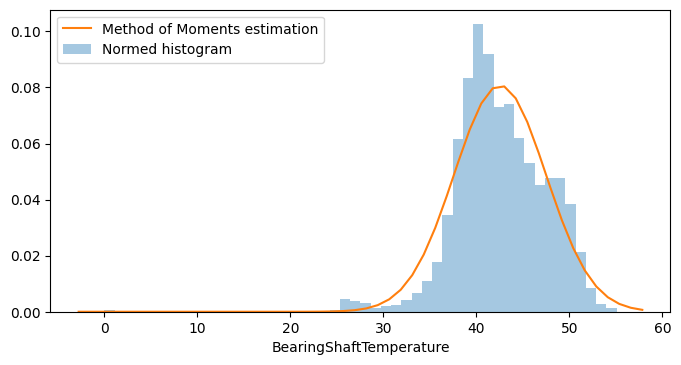

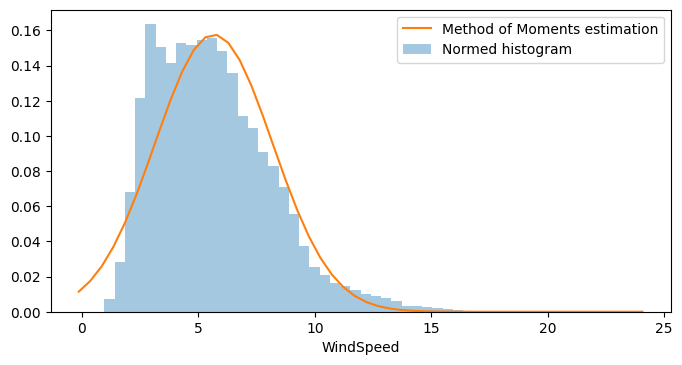

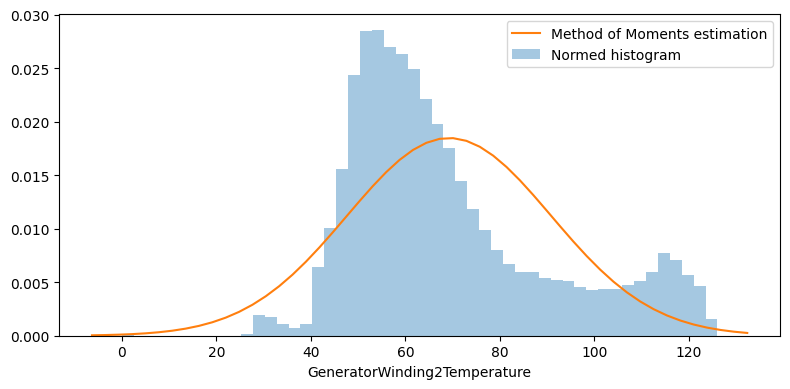

In [49]:
params_mom = {}

var_estim = {
    'BearingShaftTemperature': {
        'estim': norm,
        'params': {'loc': mu_mom['BearingShaftTemperature'], 'scale': sigma_mom['BearingShaftTemperature']}
    },
    'WindSpeed': {
        'estim': norm,
        'params': {'loc': mu_mom['WindSpeed'], 'scale': sigma_mom['WindSpeed']}
    },
    'GeneratorWinding2Temperature': {
        'estim': norm,
        'params': {'loc': mu_mom['GeneratorWinding2Temperature'], 'scale': sigma_mom['GeneratorWinding2Temperature']}
    },
}
x_vals_ls = []

for var in target_columns:
  fig = plt.figure()
  fig.set_dpi(100)
  fig.set_figheight(4)
  fig.set_figwidth(8)

  dist = sns.distplot(target_df[var], kde=False, norm_hist=True, label=f'Normed histogram')

  # Plot fitted distribution
  x = np.linspace(*dist.get_xlim())
  x_vals_ls.append(x)

  estim = var_estim[var]
  try:
    params_mom[var] = [estim['params']['a'], 0, estim['params']['scale']]
  except:
    params_mom[var] = [estim['params']['loc'], estim['params']['scale']]

  estim = estim['estim'].pdf(x=x, **estim['params'])

  plt.plot(x, estim, label='Method of Moments estimation')
  
  # Annotate with parameter estimates
  # plt.annotate(label, xy=(0, 0))
  fig.show()
  plt.legend()
  
plt.tight_layout()

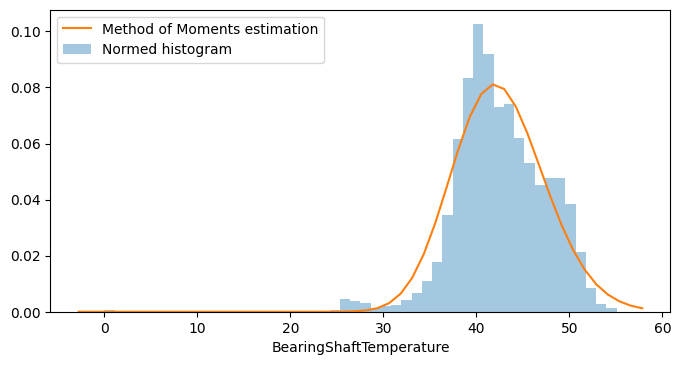

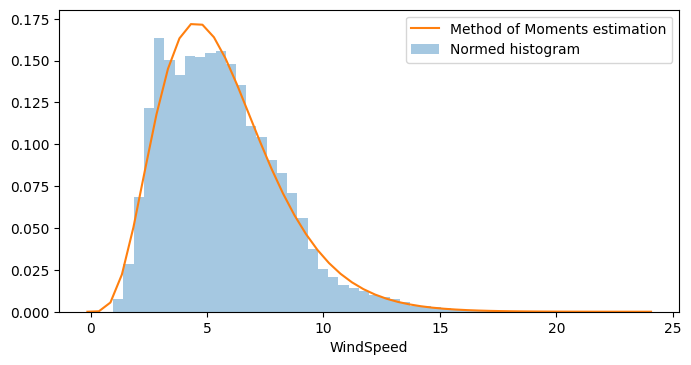

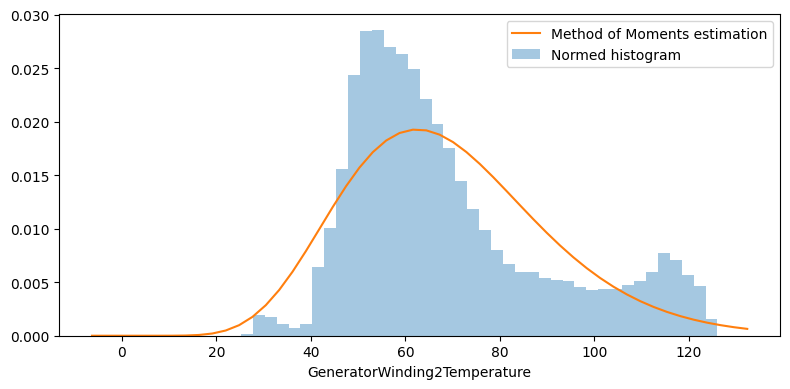

In [17]:
x_vals_ls = []

for var in target_columns:
  fig = plt.figure()
  fig.set_dpi(100)
  fig.set_figheight(4)
  fig.set_figwidth(8)

  dist = sns.distplot(target_df[var], kde=False, norm_hist=True, label=f'Normed histogram')

  # Plot fitted distribution
  x = np.linspace(*dist.get_xlim())
  x_vals_ls.append(x)

  estim = var_estim[var]
  try:
    params_mom[var] = [estim['params']['a'], 0, estim['params']['scale']]
  except:
    params_mom[var] = [estim['params']['s'], estim['params']['scale']]

  estim = estim['estim'].pdf(x=x, **estim['params'])

  plt.plot(x, estim, label='Method of Moments estimation')
  
  # Annotate with parameter estimates
  # plt.annotate(label, xy=(0, 0))
  fig.show()
  plt.legend()
  
plt.tight_layout()

# Step 2

In [18]:
import scipy.stats

In [ ]:
# ls_data = [['a', alpha_mom[0], alpha_mom[1], alpha_mom[2]], 
#             ['loc', mu_mom[0], mu_mom[1], mu_mom[2]],
#            ['scale', beta_mom[0], beta_mom[1], beta_mom[2]]]

In [19]:
def normal_pdf(x, mu_, sigma_):
    return (1 / (np.sqrt(2*np.pi)*sigma_)) * np.exp(-0.5 * ((x-mu_)/sigma_)**2)

def gamma_pdf(x, a, scale):
  return gamma.pdf(x, a=a , scale=scale)

In [ ]:
x_vals = np.arange(2, 6, 0.05)
# f_vals = [gamma_pdf(x,  alpha_mom[0], beta_mom[0]) for x in x_vals]
f_vals = gamma_pdf(x_vals,  alpha_mom[0], beta_mom[0])

f_vals

In [20]:
mu_mom

BearingShaftTemperature         42.545913
WindSpeed                        5.660227
GeneratorWinding2Temperature    69.249069
dtype: float64

In [21]:
alpha_mom

BearingShaftTemperature         74.093384
WindSpeed                        5.004518
GeneratorWinding2Temperature    10.276346
dtype: float64

In [22]:
beta_mom

BearingShaftTemperature         0.574220
WindSpeed                       1.131023
GeneratorWinding2Temperature    6.738686
dtype: float64

In [23]:
sigma_mom

BearingShaftTemperature          4.942744
WindSpeed                        2.530188
GeneratorWinding2Temperature    21.602031
dtype: float64

samplesRating Collected: 10000
Effection: 1.0


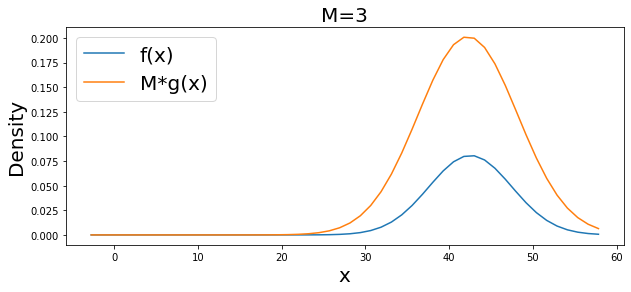

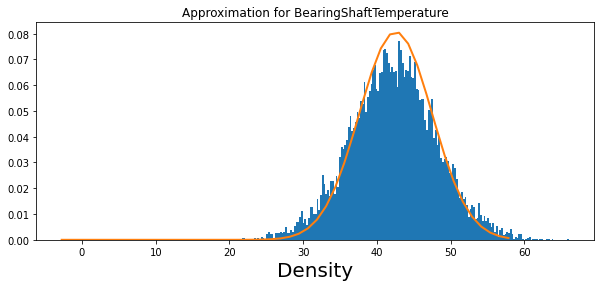

In [24]:
mu = mu_mom[0]
sigma = sigma_mom[0]

upper_mu = mu_mom[0]-0.3
upper_sigma = sigma_mom[0] + 1
upper_params = upper_mu, upper_sigma

M = 3
x_vals = x_vals_ls[0]
f_vals = [normal_pdf(x, mu, sigma) for x in x_vals]
f2_vals = normal_pdf(x_vals, *upper_params)

plt.figure(figsize=(10, 4))


plt.plot(x_vals, f_vals, label='f(x)')
plt.plot(x_vals, M*f2_vals, label='M*g(x)')

plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=20)

plt.title(f'M={M}', fontsize=20)

samplesRating = []


N = int(1e4)
for _ in range(N):
    # candidate = np.random.gamma(shape=upper_mu, upper_sigma)
    candidate = np.random.normal(*upper_params)
    prob_accept = normal_pdf(candidate, mu, sigma) / \
        (M*gamma_pdf(candidate, *upper_params))

    if np.random.random() < prob_accept:
        samplesRating.append(candidate)
        pass
    
    continue

plt.figure(figsize=(10, 4))

plt.hist(samplesRating, bins=200, density=True)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)

plt.title(f'Approximation for {target_columns[0]}')
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)

print(f'samplesRating Collected: {len(samplesRating)}')
print(f'Effection: {len(samplesRating)/N}')


# np.random.gamma(shape, scale=1.0)

samplesRating Collected: 2518
Effection: 0.2518


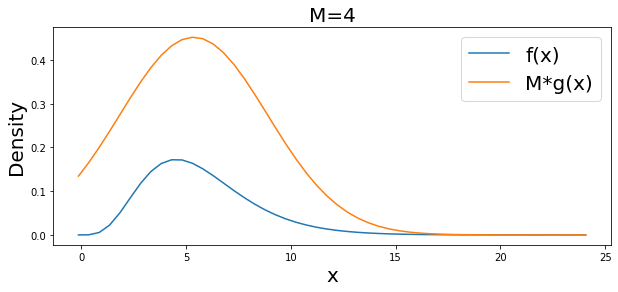

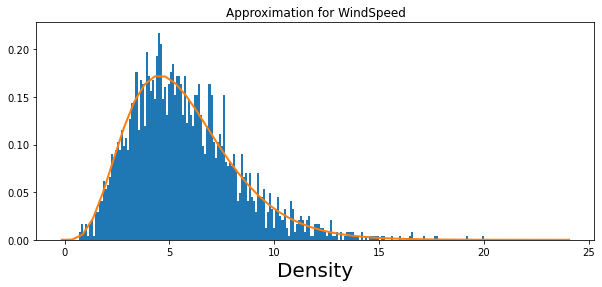

In [26]:
alpha = alpha_mom[1]
beta = beta_mom[1]

# upper_alpha = np.round(alpha)
# upper_beta =0.4
# upper_params = upper_alpha, upper_beta

upper_mu = mu_mom[1]-0.3
upper_sigma = sigma_mom[1] + 1
upper_params = upper_mu, upper_sigma

M = 4
x_vals = x_vals_ls[1]
f_vals = [gamma_pdf(x, alpha, beta) for x in x_vals]
f2_vals = normal_pdf(x_vals, *upper_params)

plt.figure(figsize=(10, 4))


plt.plot(x_vals, f_vals, label='f(x)')
plt.plot(x_vals, M*f2_vals, label='M*g(x)')

plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=20)

plt.title(f'M={M}', fontsize=20)

samplesRating = []


N = int(1e4)
for _ in range(N):
    # candidate = np.random.gamma(shape=upper_alpha, scale=upper_beta)
    candidate = np.random.normal(*upper_params)
    prob_accept = gamma_pdf(candidate, alpha, beta) / \
        (M*normal_pdf(candidate, *upper_params))

    if np.random.random() < prob_accept:
        samplesRating.append(candidate)
        pass
    
    continue

plt.figure(figsize=(10, 4))

plt.hist(samplesRating, bins=200, density=True)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)

plt.title(f'Approximation for {target_columns[1]}')
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)

print(f'samplesRating Collected: {len(samplesRating)}')
print(f'Effection: {len(samplesRating)/N}')


# np.random.gamma(shape, scale=1.0)

samplesRating Collected: 8964
Effection: 0.8964


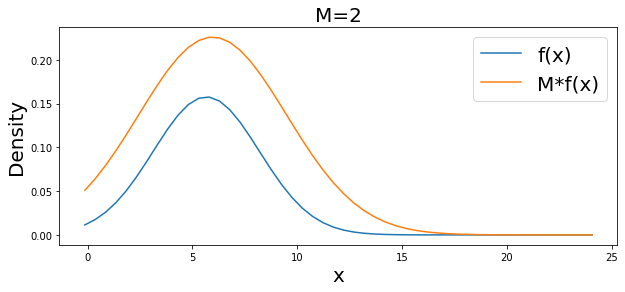

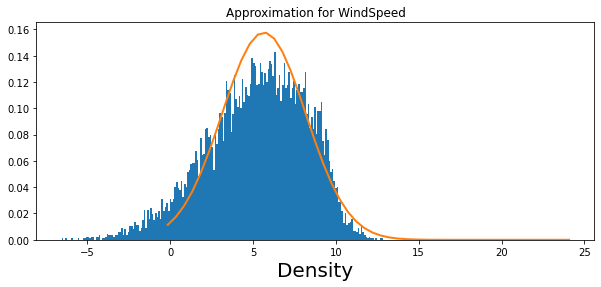

In [65]:
# i = 1
# mu = mu_mom[i]
# sigma = sigma_mom[i]

# upper_mu = mu_mom[i]+0.3
# upper_sigma = sigma_mom[i] + 1
# upper_params = upper_mu, upper_sigma

# M = 2
# x_vals = x_vals_ls[i]
# f_vals = [normal_pdf(x, mu, sigma) for x in x_vals]
# f2_vals = normal_pdf(x_vals, *upper_params)

# plt.figure(figsize=(10, 4))


# plt.plot(x_vals, f_vals, label='f(x)')
# plt.plot(x_vals, M*f2_vals, label='M*f(x)')

# plt.xlabel('x', fontsize=20)
# plt.ylabel('Density', fontsize=20)
# plt.legend(fontsize=20)


# plt.title(f'M={M}', fontsize=20)

# samplesRating = []


# N = int(1e4)
# for _ in range(N):
#     # candidate = np.random.gamma(shape=upper_mu, upper_sigma)
#     candidate = np.random.normal(*upper_params)
#     prob_accept = normal_pdf(candidate, mu, sigma) / \
#         (M*gamma_pdf(candidate, *upper_params))

#     if np.random.random() < prob_accept:
#         samplesRating.append(candidate)
#         pass
    
#     continue

# plt.figure(figsize=(10, 4))

# plt.hist(samplesRating, bins=200, density=True)
# plt.plot(x_vals, [f for f in f_vals], linewidth=2)

# plt.title(f'Approximation for {target_columns[i]}')
# plt.xlabel('x', fontsize=20)
# plt.xlabel('Density', fontsize=20)

# # print('Distribution for')
# print(f'samplesRating Collected: {len(samplesRating)}')
# print(f'Effection: {len(samplesRating)/N}')


# # np.random.gamma(shape, scale=1.0)

samplesRating Collected: 10000
Effection: 1.0


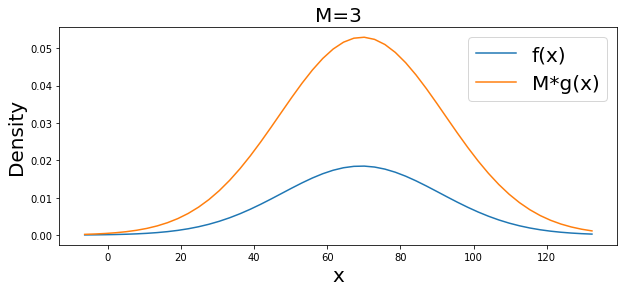

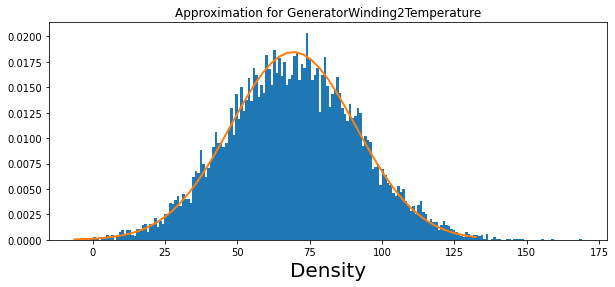

In [27]:
i = 2
mu = mu_mom[i]
sigma = sigma_mom[i]

upper_mu = mu_mom[i]+0.3
upper_sigma = sigma_mom[i] + 1
upper_params = upper_mu, upper_sigma

M = 3
x_vals = x_vals_ls[i]
f_vals = [normal_pdf(x, mu, sigma) for x in x_vals]
f2_vals = normal_pdf(x_vals, *upper_params)

plt.figure(figsize=(10, 4))


plt.plot(x_vals, f_vals, label='f(x)')
plt.plot(x_vals, M*f2_vals, label='M*g(x)')

plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=20)


plt.title(f'M={M}', fontsize=20)

samplesRating = []


N = int(1e4)
for _ in range(N):
    # candidate = np.random.gamma(shape=upper_mu, upper_sigma)
    candidate = np.random.normal(*upper_params)
    prob_accept = normal_pdf(candidate, mu, sigma) / \
        (M*gamma_pdf(candidate, *upper_params))

    if np.random.random() < prob_accept:
        samplesRating.append(candidate)
        pass
    
    continue

plt.figure(figsize=(10, 4))

plt.hist(samplesRating, bins=200, density=True)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)

plt.title(f'Approximation for {target_columns[i]}')
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)

# print('Distribution for')
print(f'samplesRating Collected: {len(samplesRating)}')
print(f'Effection: {len(samplesRating)/N}')


# np.random.gamma(shape, scale=1.0)

In [68]:
def inverse_transform_sampling(n, rand, dist, param, args=0):
    gen = rand(size=n)
    rv = dist(*param)
    return rv.ppf(gen) + args

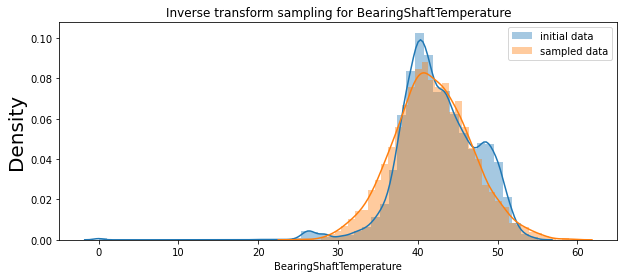

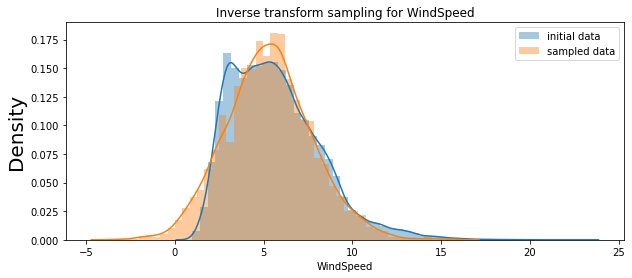

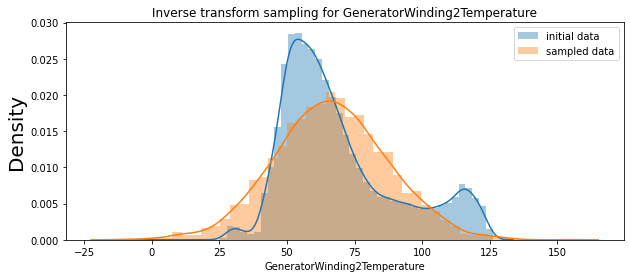

In [71]:
for i in range(len(target_columns)):
  params = stats.norm.fit(target_df[target_columns[i]])
  sampledVar = inverse_transform_sampling(
      int(1e4), np.random.normal, stats.norm, params)

  plt.figure(figsize=(10, 4))

  sns.distplot(target_df[target_columns[i]], kde=True, label='initial data')
  sns.distplot(sampledVar, kde=True,
              norm_hist=True, label='sampled data')

  plt.ylabel('Density', fontsize=20)
  plt.title(f'Inverse transform sampling for {target_columns[i]}')
  plt.legend()

# Step 3

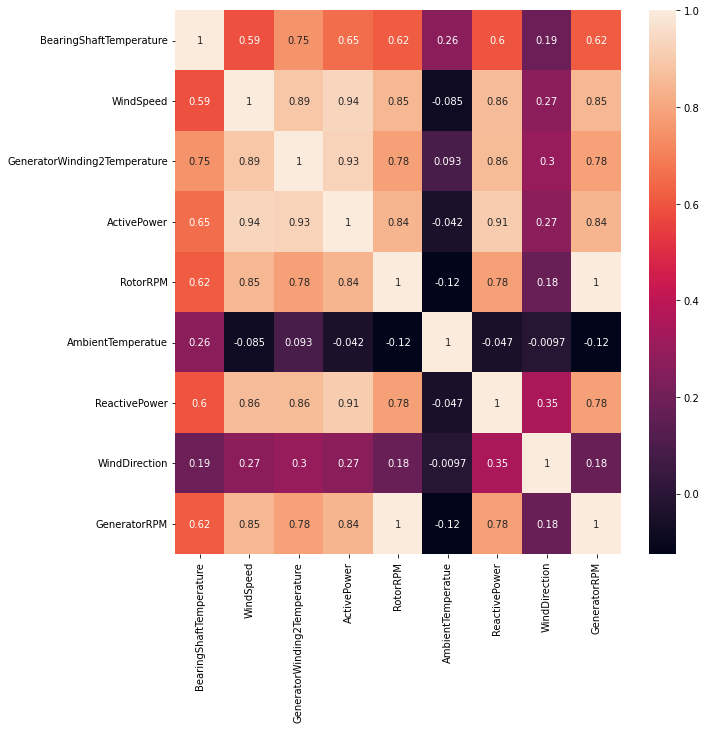

In [73]:
corrMatrix = target_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [74]:
pair_names = []
for i in range(len(all_columns)):
  for j in range(len(all_columns)):
    pair_names.append([all_columns[i], all_columns[j], 0.0])

In [76]:
for pair in pair_names:
  pair[2] = np.round(stats.pearsonr(target_df[pair[0]],target_df[pair[1]])[1], 4)
  print(f'{pair[0]}, {pair[1]}: {np.round(stats.pearsonr(target_df[pair[0]],target_df[pair[1]]), 3)[1]}')

BearingShaftTemperature, BearingShaftTemperature: 0.0
BearingShaftTemperature, WindSpeed: 0.0
BearingShaftTemperature, GeneratorWinding2Temperature: 0.0
BearingShaftTemperature, ActivePower: 0.0
BearingShaftTemperature, RotorRPM: 0.0
BearingShaftTemperature, AmbientTemperatue: 0.0
BearingShaftTemperature, ReactivePower: 0.0
BearingShaftTemperature, WindDirection: 0.0
BearingShaftTemperature, GeneratorRPM: 0.0
WindSpeed, BearingShaftTemperature: 0.0
WindSpeed, WindSpeed: 0.0
WindSpeed, GeneratorWinding2Temperature: 0.0
WindSpeed, ActivePower: 0.0
WindSpeed, RotorRPM: 0.0
WindSpeed, AmbientTemperatue: 0.0
WindSpeed, ReactivePower: 0.0
WindSpeed, WindDirection: 0.0
WindSpeed, GeneratorRPM: 0.0
GeneratorWinding2Temperature, BearingShaftTemperature: 0.0
GeneratorWinding2Temperature, WindSpeed: 0.0
GeneratorWinding2Temperature, GeneratorWinding2Temperature: 0.0
GeneratorWinding2Temperature, ActivePower: 0.0
GeneratorWinding2Temperature, RotorRPM: 0.0
GeneratorWinding2Temperature, AmbientTemp

# Step 4

In [87]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 20.0 MB/s 


In [145]:
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BicScore, K2Score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork

from sklearn.metrics import mean_absolute_percentage_error as mape
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from math import sqrt
import networkx as nx
from sklearn.metrics import accuracy_score

In [123]:
trg_df = target_df.iloc[:3000]
trg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BearingShaftTemperature       3000 non-null   float64
 1   WindSpeed                     3000 non-null   float64
 2   GeneratorWinding2Temperature  3000 non-null   float64
 3   ActivePower                   3000 non-null   float64
 4   RotorRPM                      3000 non-null   float64
 5   AmbientTemperatue             3000 non-null   float64
 6   ReactivePower                 3000 non-null   float64
 7   WindDirection                 3000 non-null   float64
 8   GeneratorRPM                  3000 non-null   float64
dtypes: float64(9)
memory usage: 211.1 KB


In [124]:
bayes_df = trg_df.copy()
bayes_df.head()

,BearingShaftTemperature,WindSpeed,GeneratorWinding2Temperature,ActivePower,RotorRPM,AmbientTemperatue,ReactivePower,WindDirection,GeneratorRPM
0,47.471346,15.061125,110.699257,1723.840739,15.702706,27.559161,0.015372,89.00,1751.589089
1,42.126495,11.791917,110.578340,1713.430541,15.780975,27.516543,0.279944,89.00,1759.218300
2,47.375546,13.433922,110.334352,1724.986578,15.703549,27.538246,-0.225979,89.00,1752.282056
3,47.125813,13.016989,110.191098,1710.218095,15.725234,27.454070,0.523854,95.00,1751.914460
4,41.924676,12.377344,110.098841,1716.371633,15.760685,27.404938,0.607706,94.25,1757.314711


In [125]:
discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="kmeans")
df_descrete = discretizer.fit_transform(bayes_df.values)
df_descrete = pd.DataFrame(df_descrete, columns=all_columns)
df_descrete.head()

df_prob = df_descrete.iloc[:1500, :].copy()
df_trans = df_descrete.iloc[1500:,:].copy()

In [120]:
all_columns

['BearingShaftTemperature',
 'WindSpeed',
 'GeneratorWinding2Temperature',
 'ActivePower',
 'RotorRPM',
 'AmbientTemperatue',
 'ReactivePower',
 'WindDirection',
 'GeneratorRPM']

In [121]:
# modeling edges based on the analisys from step 3

model = BayesianModel([
    ('BearingShaftTemperature', 'ActivePower'),
    ('WindSpeed', 'RotorRPM'),
    ('GeneratorWinding2Temperature', 'RotorRPM'),
    ('GeneratorWinding2Temperature', 'ReactivePower'),
    ('BearingShaftTemperature', 'WindDirection'),
    ('BearingShaftTemperature', 'GeneratorRPM'),
    ('WindSpeed', 'RotorRPM'),
    ('GeneratorWinding2Temperature','ActivePower'),
    ('WindSpeed', 'ActivePower'),
    ('WindSpeed', 'GeneratorRPM')
])

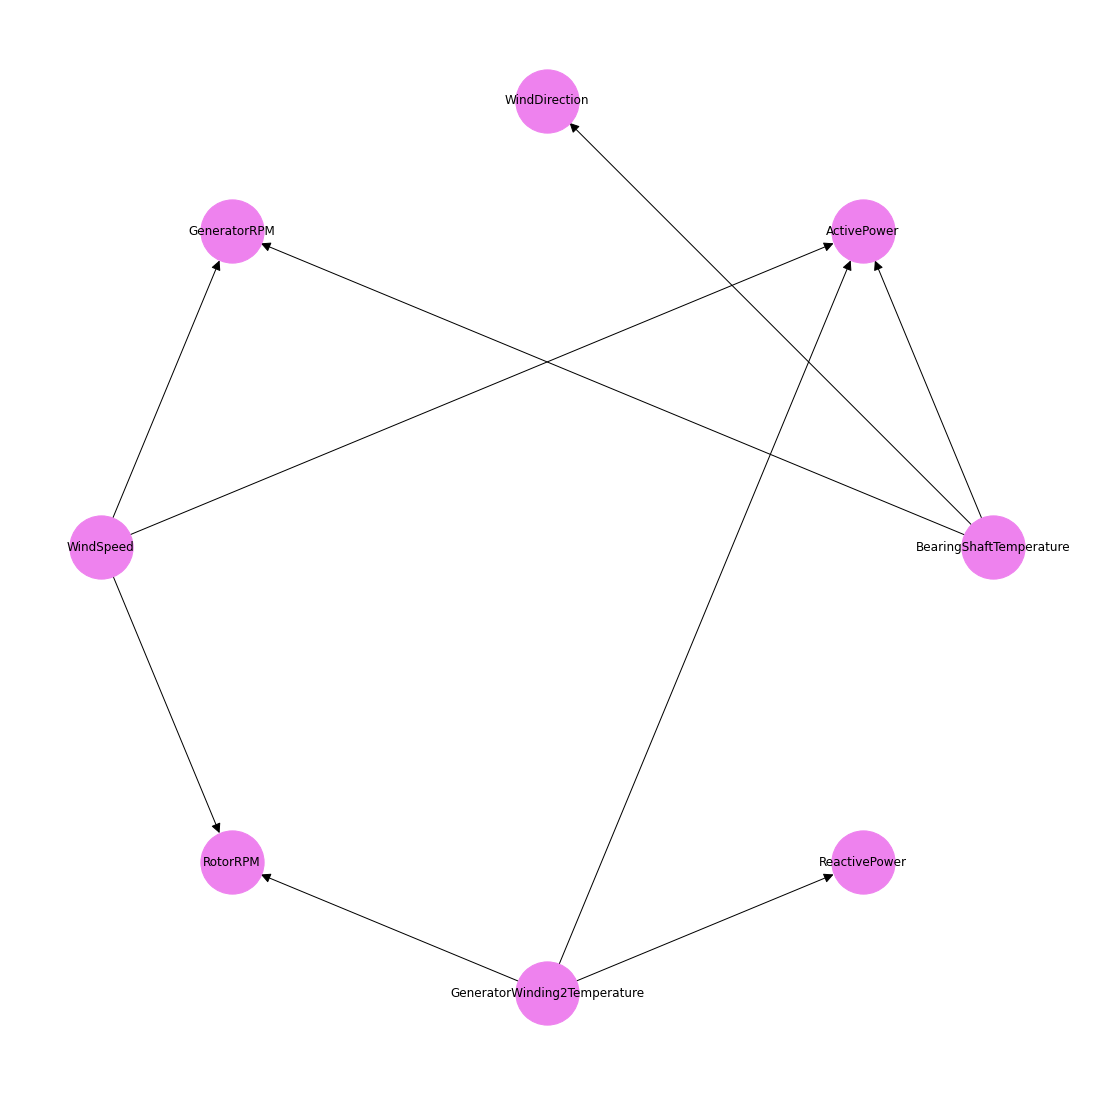

In [122]:
network = nx.DiGraph()
network.add_edges_from(model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(15, 15))
nx.draw(network, pos, with_labels=True, node_color='violet', node_size=4000, arrowsize=20)

In [130]:
model.fit(df_trans)
print(f"K2 score of created model {K2Score(df_trans).score(model):.2f}")
print(f"BIC score of created model {BicScore(df_trans).score(model):.2f}")

K2 score of created model -16489.69
BIC score of created model -35465.94


# Step 5

**Hill climbing search**

In [99]:
hc_search = HillClimbSearch(data=df_descrete)
model_k2 = hc_search.estimate(scoring_method=K2Score(df_descrete), show_progress=False)

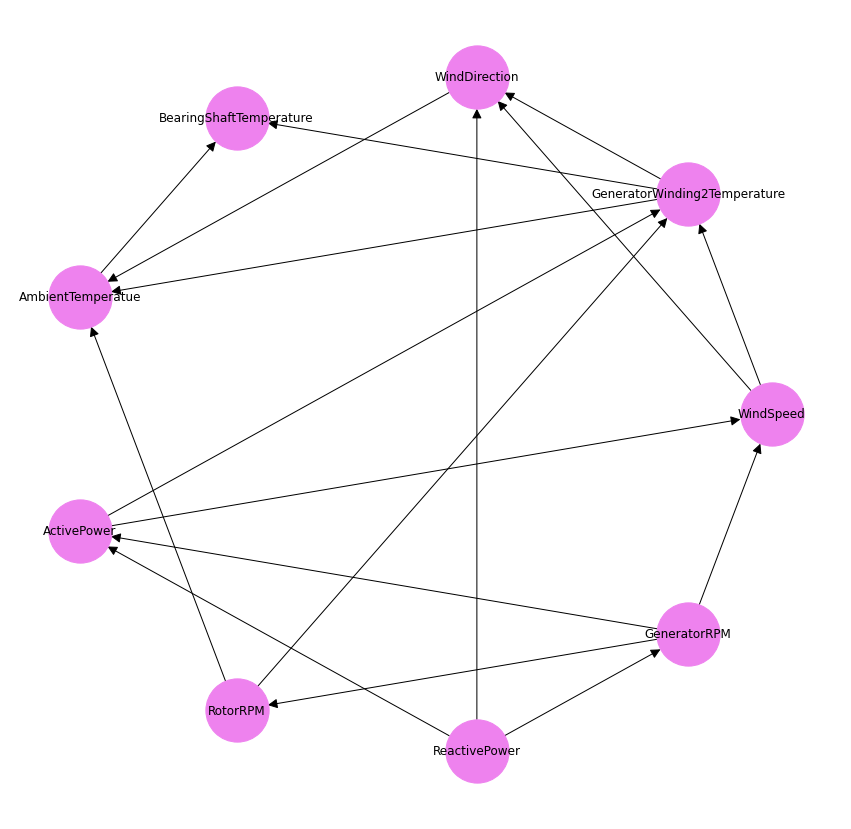

In [111]:
fig, ax = plt.subplots(figsize=(15, 15))
# fig, ax = plt.subplots(figsize=(10,10))

G = nx.DiGraph()
G.add_edges_from(model_k2.edges())
positions = nx.layout.circular_layout(G)
nx.draw(G, positions, with_labels=True, node_color='violet', node_size=4000, arrowsize=20)

In [131]:
print(f"K2 score of unconstrained model {K2Score(df_descrete).score(model_k2):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_descrete).score(model_k2):.2f}")

K2 score of unconstrained model -32285.23
BIC score of unconstrained model -145650.79


**Tree search**

Building tree:   0%|          | 0/36.0 [00:00<?, ?it/s]

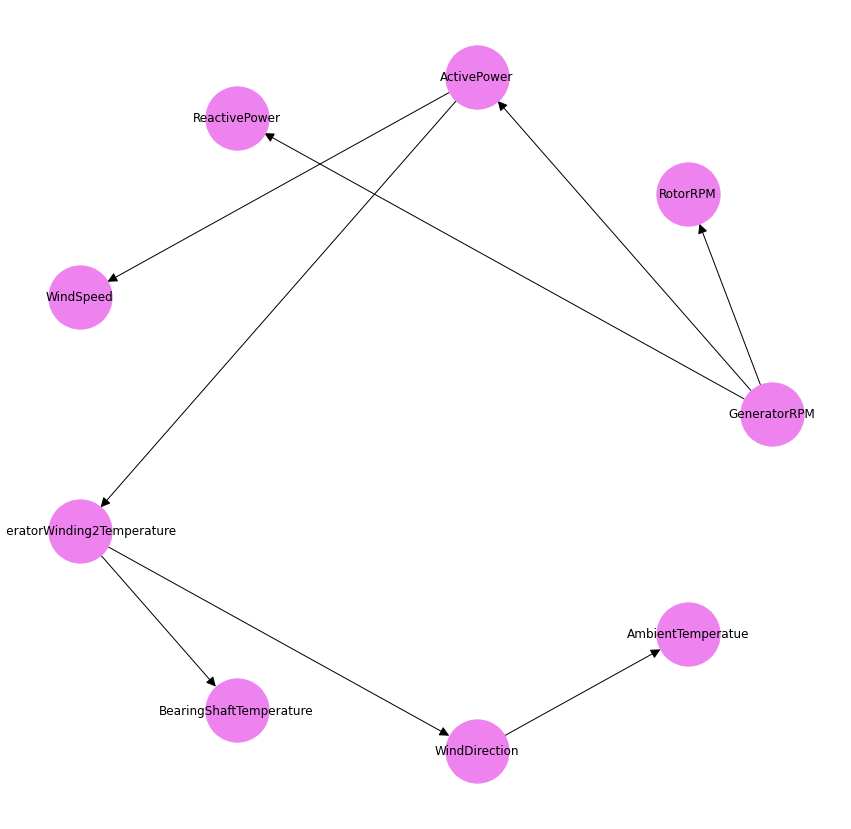

In [133]:
ts = TreeSearch(df_descrete)
model_ts = ts.estimate()
g_K2 = nx.DiGraph()
g_K2.add_edges_from(model_ts.edges())
pos = nx.layout.circular_layout(g_K2)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(g_K2, pos, with_labels=True,node_color='violet', node_size=4000, arrowsize=20)

In [134]:
print(f"K2 score of unconstrained model {K2Score(df_descrete).score(model_ts):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_descrete).score(model_ts):.2f}")

K2 score of unconstrained model -31748.15
BIC score of unconstrained model -32416.46


# Step 6

In [135]:
def sampling(bn, data, n, new: bool = False):
    if new:
        bn_new = BayesianModel(bn.edges())
        bn_new.fit(data)
    else:
        bn_new = bn
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [137]:
df_samples = sampling(model, df_prob, n=df_descrete.shape[0], new=True)
df_samples

  0%|          | 0/8 [00:00<?, ?it/s]

,BearingShaftTemperature,ActivePower,WindDirection,GeneratorRPM,WindSpeed,RotorRPM,GeneratorWinding2Temperature,ReactivePower
0,9.0,7.0,3.0,9.0,1.0,5.0,0.0,0.0
1,9.0,6.0,1.0,7.0,1.0,9.0,9.0,1.0
2,8.0,4.0,2.0,8.0,4.0,7.0,3.0,1.0
3,3.0,7.0,4.0,5.0,8.0,5.0,6.0,1.0
4,8.0,6.0,2.0,1.0,1.0,2.0,9.0,1.0
...,...,...,...,...,...,...,...,...
2995,7.0,7.0,3.0,0.0,3.0,5.0,2.0,1.0
2996,8.0,9.0,3.0,9.0,5.0,9.0,9.0,1.0
2997,9.0,4.0,2.0,7.0,3.0,7.0,5.0,1.0
2998,8.0,8.0,2.0,8.0,5.0,2.0,3.0,1.0


In [138]:
df_descrete.head()

,BearingShaftTemperature,WindSpeed,GeneratorWinding2Temperature,ActivePower,RotorRPM,AmbientTemperatue,ReactivePower,WindDirection,GeneratorRPM
0,8.0,9.0,9.0,9.0,9.0,6.0,1.0,1.0,9.0
1,7.0,7.0,9.0,9.0,9.0,6.0,1.0,1.0,9.0
2,8.0,8.0,9.0,9.0,9.0,6.0,1.0,1.0,9.0
3,8.0,8.0,9.0,9.0,9.0,6.0,1.0,2.0,9.0
4,7.0,8.0,9.0,9.0,9.0,6.0,1.0,2.0,9.0


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

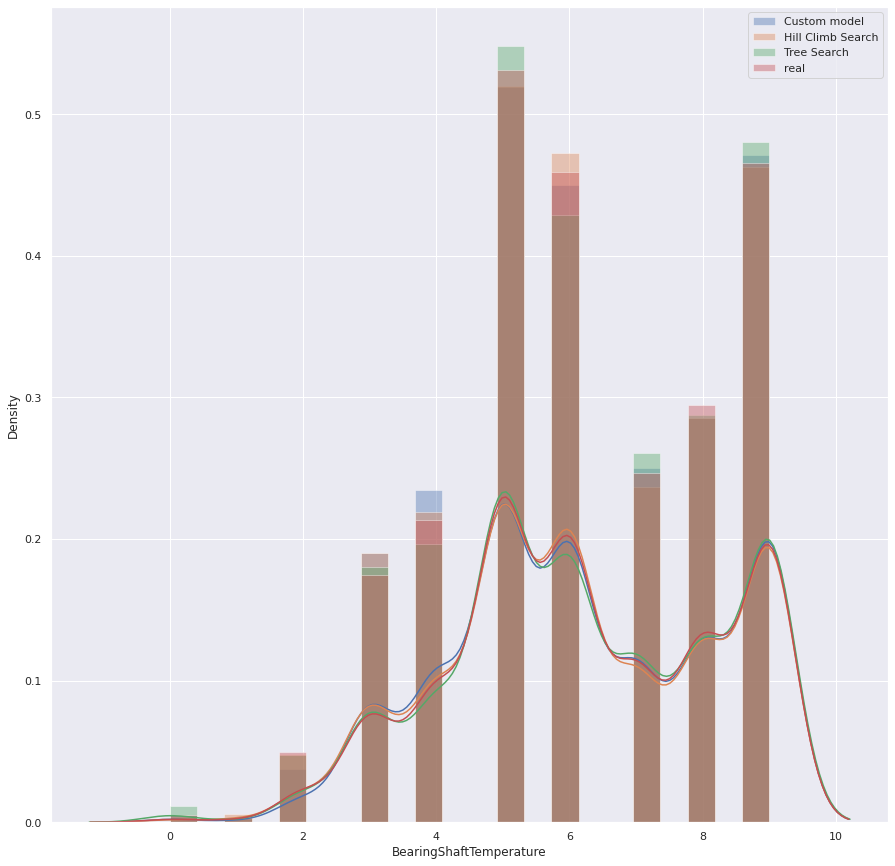

In [141]:
custom_res = sampling(model, df_descrete, n=df_descrete.shape[0], new=True)
hc_res = sampling(model_k2, df_descrete, n=df_descrete.shape[0], new=True)
ts_res = sampling(model_ts, df_descrete, n=df_descrete.shape[0], new=True)

sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(custom_res['BearingShaftTemperature'], label='Custom model')
sns.distplot(hc_res['BearingShaftTemperature'], label='Hill Climb Search')
sns.distplot(ts_res['BearingShaftTemperature'], label='Tree Search')
sns.distplot(df_descrete['BearingShaftTemperature'], label='real')
plt.legend()
plt.show()

In [142]:
target_columns

['BearingShaftTemperature', 'WindSpeed', 'GeneratorWinding2Temperature']

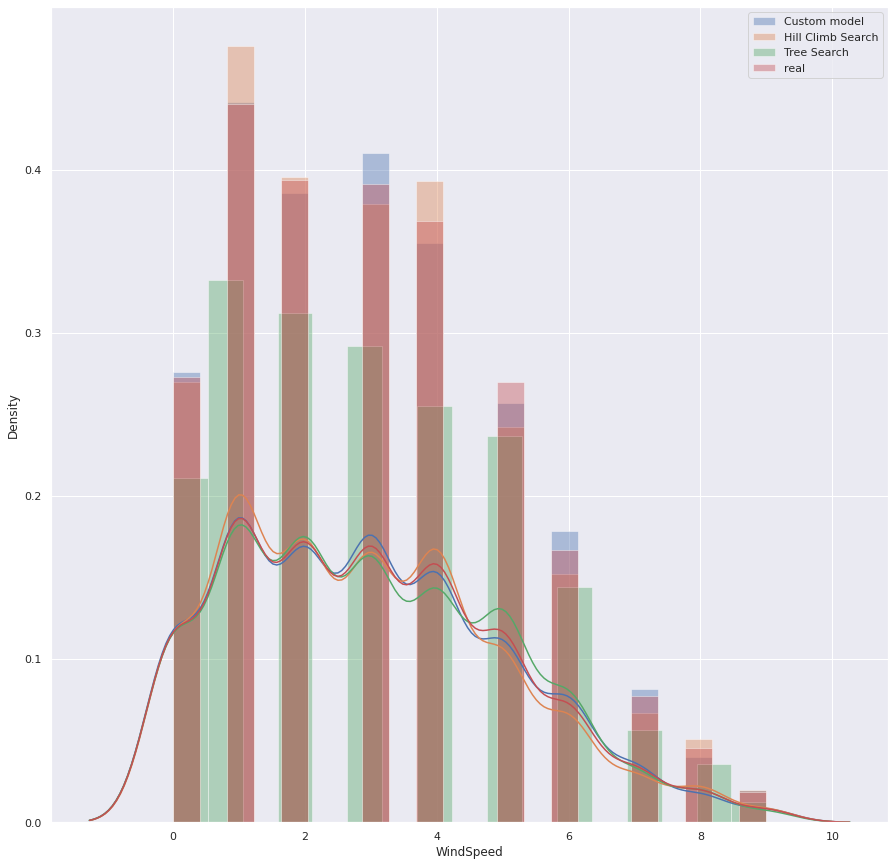

In [143]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(custom_res['WindSpeed'], label='Custom model')
sns.distplot(hc_res['WindSpeed'], label='Hill Climb Search')
sns.distplot(ts_res['WindSpeed'], label='Tree Search')
sns.distplot(df_descrete['WindSpeed'], label='real')
plt.legend()
plt.show()

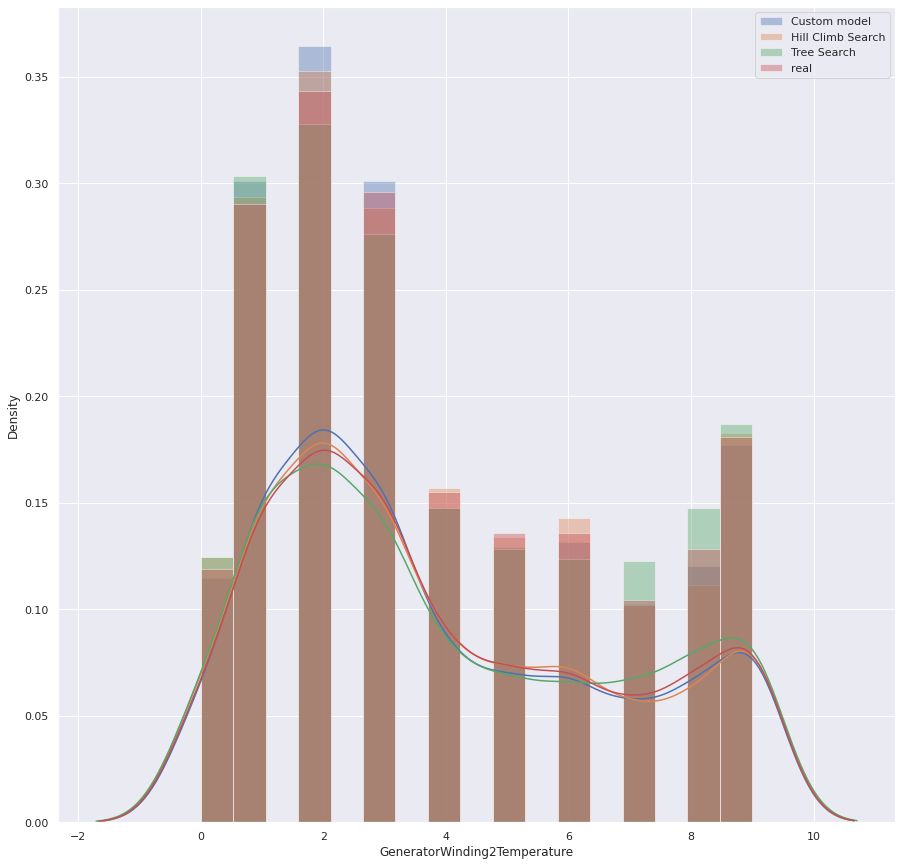

In [144]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(custom_res['GeneratorWinding2Temperature'], label='Custom model')
sns.distplot(hc_res['GeneratorWinding2Temperature'], label='Hill Climb Search')
sns.distplot(ts_res['GeneratorWinding2Temperature'], label='Tree Search')
sns.distplot(df_descrete['GeneratorWinding2Temperature'], label='real')
plt.legend()
plt.show()

In [148]:
def print_metrics(title, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # print()
    print(f'Metrics of {title}')
    print('Mean absolute error:', mae)
    print('Mean squared error:', mse)
    # print(f'R^2: {metrics.r2_score(y_test, y_pred)}')
    print()

In [154]:
for column in target_columns:
  print('Target:', column)
  print_metrics('Custom model metrics', df_descrete[column], custom_res[column])

Target: BearingShaftTemperature
Metrics of Custom model metrics
Mean absolute error: 2.2616666666666667
Mean squared error: 7.904333333333334

Target: WindSpeed
Metrics of Custom model metrics
Mean absolute error: 2.361666666666667
Mean squared error: 8.743

Target: GeneratorWinding2Temperature
Metrics of Custom model metrics
Mean absolute error: 3.066333333333333
Mean squared error: 15.064333333333334



In [153]:
for column in target_columns:
  print('Target:', column)
  print_metrics('C.h. model metrics', df_descrete[column], hc_res[column])

Target: BearingShaftTemperature
Metrics of C.h. model metrics
Mean absolute error: 2.2626666666666666
Mean squared error: 8.03

Target: WindSpeed
Metrics of C.h. model metrics
Mean absolute error: 2.3263333333333334
Mean squared error: 8.861

Target: GeneratorWinding2Temperature
Metrics of C.h. model metrics
Mean absolute error: 3.089
Mean squared error: 15.395



In [152]:
for column in target_columns:
  print('Target:', column)
  print_metrics('C.h. model metrics', df_descrete[column], ts_res[column])

Target: BearingShaftTemperature
Metrics of C.h. model metrics
Mean absolute error: 2.245
Mean squared error: 7.969

Target: WindSpeed
Metrics of C.h. model metrics
Mean absolute error: 2.345
Mean squared error: 8.651

Target: GeneratorWinding2Temperature
Metrics of C.h. model metrics
Mean absolute error: 3.119666666666667
Mean squared error: 15.355

